In [1]:
# code to generate yearly summaries of DUNE data volumes from input parameters
# rewritten from the version in the CDR - mainly by using maps of years instead of arrays to make it clearer what is in each year.
# HMS 2022-10-23


import os,sys,string,time,commentjson,datetime, math
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DEBUG = False
DRAW = False

import numpy as np

from NumberUtils import dump
from NumberUtils import DrawTex
from NumberUtils import cumulateMap
from NumberUtils import DrawDet
from NumberUtils import DrawType
from NumberUtils import makeArray
from NumberUtils import ToCSV1
from NumberUtils import ToCSV2


In [2]:
# read in a configfile
configfile = "Parameters_2022-10-23-2040.json"

#if len(sys.argv) > 1:
#  configfile = sys.argv[1]

shortname = configfile.replace(".json","")
if os.path.exists(configfile):
  with open(configfile,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfile)
  sys.exit(0)

if not "Version" in config or config["Version"] < 5:
  print (" this code expects Version >= 2")
  sys.exit(1)

json_formatted_str = commentjson.dumps(config, indent=2)

In [3]:
MaxYear = config["MaxYear"]

MinYear = config["MinYear"]
Detectors = config["Detectors"]
if DEBUG:
  Detectors = ["SP","SP2","DP"]
Years = np.array(config["Years"])
if DEBUG:
  Years = Years[0:7]
shortname = shortname.replace("2040","%d"%MaxYear)
print (Years, len(Years))
size = len(Years)

Units = config["Units"]

Detectors = config["Detectors"]

print (Detectors)

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())
if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

# this is how far you go back each time you reprocess reco.
Reprocess = config["Reprocess"]

PerYear = config["PerYear"]

StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

PatternFraction = config["PatternFraction"]

SplitsYear = config["SplitsYear"]
SplitsEarly = config["SplitsEarly"]
SplitsLater = config["SplitsLater"]


[2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040] 23
['SP', 'SP2', 'DP', 'PDVD', 'HD', 'VD', 'ND']


In [4]:
dofirst = ["Events","Test","Sim Events"]

# read in the raw information

Inputs = {}
for det in Detectors:
  Inputs[det]={}
  for type in dofirst:
      Inputs[det][type]={}
      for year in Years:
          Inputs[det][type][year] = float(config[det][type][year-Years[0]])

# fill in other useful arrays
for det in Detectors:
  if DEBUG: print ("Events",det,Inputs[det]["Events"])
  for key in DetectorParameters:
    # skip the ones already done
    if key in dofirst:
      continue
    # sim has its own configuration
    # print ("this is the key",det,key)
    if not "Sim" in key:
      if key in ["CPU","Reco"]:  # if doing reco, do over previous events using memory
            Inputs[det][key] = cumulateMap(Years,Inputs[det]["Events"],Reprocess[det])
            for year in Years:
                Inputs[det][key][year] *= config[det][key]
      else:
        if key == "Raw":
            Inputs[det][key] ={}
            for year in Years:
                Inputs[det][key][year] = Inputs[det]["Events"][year]*config[det][key]
        else:
            continue
    else:
        Inputs[det][key] ={}
        for year in Years:
            Inputs[det][key][year]=Inputs[det]["Sim Events"][year]*config[det][key]

In [5]:
# make a data file which uses # of events to figure out how big samples are

if PerYear["Reco"]!=PerYear["CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco"] = PerYear["CPU"]
if PerYear["Sim"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim"] = PerYear["Sim-CPU"]

Data = {}
dump = open("dump.txt",'w')
#print (Inputs.keys())
fields = list(Inputs["ND"].keys())
for dtype in fields:
  Data[dtype] = {}
  for det in Inputs.keys():
    Data[dtype][det] = {}
    # this allows you to, say, do 2 passes of reco/year
    for year in Years:
        Data[dtype][det][year] = Inputs[det][dtype][year] * float(PerYear[dtype])
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
        for year in Years:
            Data[dtype][det][year] *= 0.001
    ds = "data %s %s %f\n"%(dtype,det,Data[dtype][det][2022])
    dump.write(ds)

In [6]:
PlotYears = []
for i in range(MinYear,MaxYear-1):
    PlotYears.append(i)
PlotYears = Years

# draw things

if DRAW:
    DrawDet(shortname,"Events",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"Raw",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"Test",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"Sim Events",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"Sim",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
    DrawDet(shortname,"Reco",Years,Data,Inputs.keys(),Units,DetColors,DetLines)

In [7]:
# merge far detector info

print ("Data keys",Data.keys())

for dtype in Data.keys():
   
    det = "ProtoDUNEs" 
    Data[dtype][det] = {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["SP"][year] + Data[dtype]["DP"][year] + Data[dtype]["SP2"][year] + Data[dtype]["PDVD"][year]

    Data[dtype].pop("SP")
    Data[dtype].pop("SP2")
    Data[dtype].pop("DP")
    Data[dtype].pop("PDVD")

Data keys dict_keys(['Events', 'Test', 'Sim Events', 'Raw', 'CPU', 'Sim-CPU', 'Reco', 'Sim'])


In [8]:
# merge far detector into "FDs
for dtype in Data.keys():
  det = "FDs"
  Data[dtype][det] =  {}
  for year in Years:  
      Data[dtype][det][year] = Data[dtype]["HD"][year] + Data[dtype]["VD"][year]
  Data[dtype].pop("HD")
  Data[dtype].pop("VD")


In [9]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
    Data["Total-CPU"][det] =  {}
    for year in Years:
        Data["Total-CPU"][det][year] = Data["CPU"][det][year] + Data["Sim-CPU"][det][year]
    print(det,Data["Total-CPU"][det])

# do I want to remove CPU as a category? 
Data.pop("CPU")

ProtoDUNEs {2018: 3.69203, 2019: 12.63436, 2020: 13.867939999999999, 2021: 17.217859999999998, 2022: 21.48403, 2023: 32.19245, 2024: 35.442499999999995, 2025: 31.609, 2026: 15.917, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
FDs {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 7.574999999999999, 2023: 4.574999999999999, 2024: 2.325, 2025: 5.325, 2026: 5.325, 2027: 7.574999999999999, 2028: 10.325, 2029: 14.725, 2030: 20.775, 2031: 26.825, 2032: 32.875, 2033: 44.97500000000001, 2034: 57.075, 2035: 69.175, 2036: 81.27499999999999, 2037: 93.375, 2038: 105.475, 2039: 117.57499999999999, 2040: 129.67499999999998}
ND {2018: 0.0, 2019: 0.0, 2020: 1.2, 2021: 3.0, 2022: 1.2, 2023: 1.2, 2024: 1.2, 2025: 1.2, 2026: 1.2, 2027: 1.2, 2028: 1.2, 2029: 1.2, 2030: 12.0, 2031: 12.0, 2032: 13.25, 2033: 14.5, 2034: 15.75, 2035: 17.0, 2036: 18.25, 2037: 19.5, 2038: 20.75, 2039: 22.0, 2040: 23.25}


{'ND': {2018: 0.0,
  2019: 0.0,
  2020: 0.0,
  2021: 0.0,
  2022: 0.0,
  2023: 0.0,
  2024: 0.0,
  2025: 0.0,
  2026: 0.0,
  2027: 0.0,
  2028: 0.0,
  2029: 0.0,
  2030: 0.0,
  2031: 0.0,
  2032: 1.25,
  2033: 2.5,
  2034: 3.75,
  2035: 5.0,
  2036: 6.25,
  2037: 7.5,
  2038: 8.75,
  2039: 10.0,
  2040: 11.25},
 'ProtoDUNEs': {2018: 1.81703,
  2019: 5.134359999999999,
  2020: 6.367939999999999,
  2021: 5.967859999999999,
  2022: 6.48403,
  2023: 13.442450000000001,
  2024: 16.6925,
  2025: 12.859,
  2026: 4.667,
  2027: 0.0,
  2028: 0.0,
  2029: 0.0,
  2030: 0.0,
  2031: 0.0,
  2032: 0.0,
  2033: 0.0,
  2034: 0.0,
  2035: 0.0,
  2036: 0.0,
  2037: 0.0,
  2038: 0.0,
  2039: 0.0,
  2040: 0.0},
 'FDs': {2018: 0.0,
  2019: 0.0,
  2020: 0.0,
  2021: 0.0,
  2022: 0.0,
  2023: 0.0,
  2024: 0.0,
  2025: 0.0,
  2026: 0.0,
  2027: 0.0,
  2028: 2.75,
  2029: 7.15,
  2030: 13.2,
  2031: 19.25,
  2032: 25.3,
  2033: 37.400000000000006,
  2034: 49.5,
  2035: 61.6,
  2036: 73.69999999999999,
  2037: 

In [10]:
# make totals across categories. 

DataTypes = list(Data.keys())

for dt in DataTypes:
    Data[dt]["Total"] = {}
    for year in Years:
        Data[dt]["Total"][year]=0.0
    for k in Data[dt].keys():
        if k == "Total":
          continue  
        for year in Years:
            Data[dt]["Total"][year] += Data[dt][k][year]
    

In [11]:
Data["Total-CPU"]["Analysis"]= {}
for year in Years:
    Data["Total-CPU"]["Analysis"][year]= 0.0
    
for det in config["Analysis"]["Add"]:
    for year in Years:
    # scale allows you to change the scale of analysis relative to reconstruction and simulations
          Data["Total-CPU"]["Analysis"][year]+= Data["Total-CPU"][det][year]*config["Analysis"]["Scale"]
    
# and put it in the total

for year in Years:
    Data["Total-CPU"]["Total"][year] += Data["Total-CPU"]["Analysis"][year]



In [12]:
# and make a special data type for cores

Data["Cores"] = {}
Data["HS06"] = {}
Data["WALL"] = {}
 
MHrsPerYear = 1000000./365./24.
for k in Data["Total-CPU"].keys():
    if "MARS" not in k :
        efficiency = config["Cores"]["Efficiency"]
    else:
        efficiency = 1

    scaleTo2020 = config["Cores"]["2020Units"]
    Data["Cores"][k]={}
    Data["HS06"][k]={}
    Data["WALL"][k]={}
    for year in Years:
        Data["Cores"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020
        Data["HS06"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020*config["kHEPSPEC06PerCPU"]
        Data["WALL"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020


In [13]:
ToCSV2("CoresbyDet","Cores",Data,Units)

In [14]:
# work out split between different institutions

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
            Splits[f][t][loc] = {}
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in Years:
                if y < SplitsYear:
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]

In [15]:
# now do some cumulative work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Data["Total"] = {}
Data["Collab"] = {}
Data["FNAL"] = {}
Data["CERN"] = {}
Data["Total"]["Cumulative Tape"] = {}
Data["Total"]["Cumulative Disk"] = {}
Data["FNAL"]["Cumulative Tape"] = {}
Data["FNAL"]["Cumulative Disk"] = {}
Data["CERN"]["Cumulative Tape"] = {}
Data["CERN"]["Cumulative Disk"] = {}
Data["Collab"]["Cumulative Tape"] = {}
Data["Collab"]["Cumulative Disk"] = {}


for year in Years:
    Data["Total"]["Cumulative Tape"][year] = 0.0
    Data["Total"]["Cumulative Disk"][year] = 0.0

for k in StorageTypes:
    Data[k]["Tape"] = {}
    Data[k]["Disk"] = {}
    for year in Years:
        Data[k]["Tape"][year] = Data[k]["Total"][year]*TapeCopies[k]
        Data[k]["Disk"][year] = Data[k]["Total"][year]*DiskCopies[k]
    Data[k]["Cumulative Tape"] = cumulateMap(Years,Data[k]["Tape"],TapeLifetimes[k])
    Data[k]["Cumulative Disk"] = cumulateMap(Years,Data[k]["Disk"],DiskLifetimes[k])
    
    for year in Years:
        Data["Total"]["Cumulative Tape"][year] += Data[k]["Cumulative Tape"][year]
        Data["Total"]["Cumulative Disk"][year] += Data[k]["Cumulative Disk"][year]
        
for loc in Splits["Disk"]["Raw"]:
    for year in Years:
        Data[loc]["Cumulative Disk"][year] = 0.0
        Data[loc]["Cumulative Tape"][year] = 0.0       
        for k in StorageTypes:
              Data[loc]["Cumulative Disk"][year] += Data[k]["Cumulative Disk"][year]*Splits["Disk"][k][loc][year]
              Data[loc]["Cumulative Tape"][year] += Data[k]["Cumulative Tape"][year]*Splits["Tape"][k][loc][year]


In [16]:
ToCSV1("Disk_by_location","Total","Cumulative Disk",Data,Units)

Total dict_keys(['Cumulative Tape', 'Cumulative Disk'])
CSV1 ['Events', 'Test', 'Sim Events', 'Raw', 'Sim-CPU', 'Reco', 'Sim', 'Total-CPU', 'Cores', 'HS06', 'WALL', 'Total', 'Collab', 'FNAL', 'CERN']
no such key Total Cumulative Disk
no such key Total Cumulative Disk
no such key Total Cumulative Disk
no such key Total Cumulative Disk
no such key Total Cumulative Disk
no such key Total Cumulative Disk
no such key Total Cumulative Disk


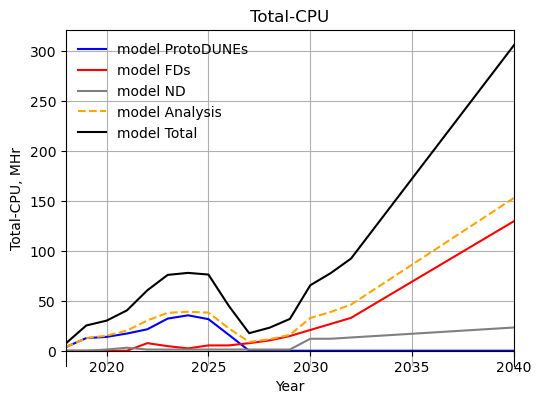

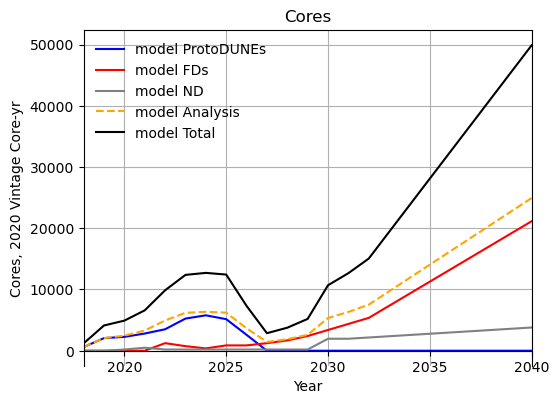

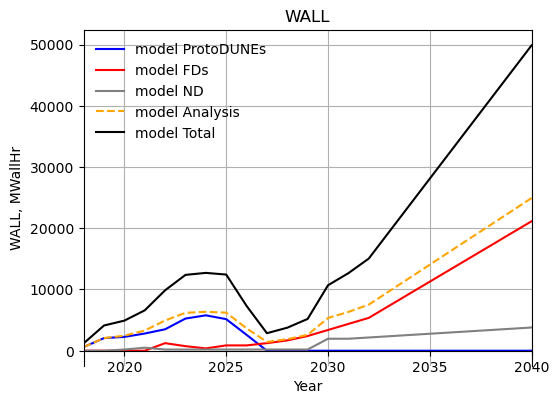

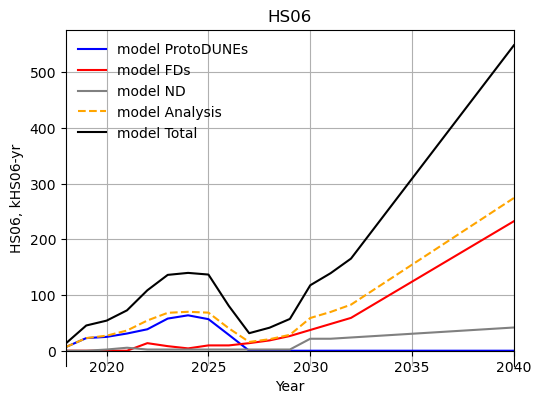

In [17]:
# now do some plots

Types = ["ProtoDUNEs","FDs","ND", "Analysis","Total"]

cpuactual = []
coreactual = []
wallactual = []


DrawDet(shortname,"Total-CPU",Years,Data,Types,Units,DetColors,DetLines,cpuactual)
DrawDet(shortname,"Cores",Years,Data,Types,Units,DetColors,DetLines,coreactual)
DrawDet(shortname,"WALL",Years,Data,Types,Units,DetColors,DetLines,wallactual)
DrawDet(shortname,"HS06",Years,Data,Types,Units,DetColors,DetLines,wallactual)

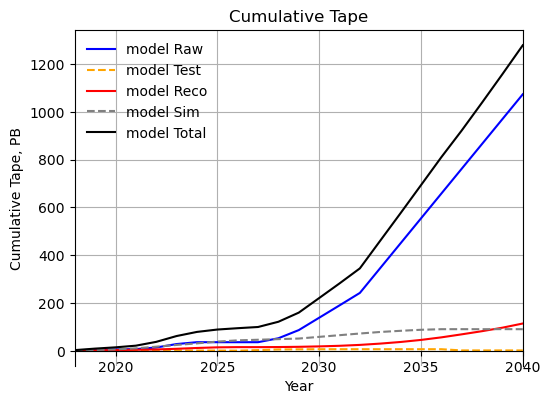

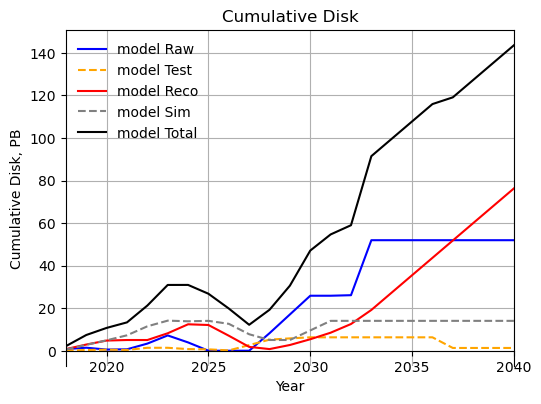

In [18]:

tapepoints = np.zeros(len(Years))
diskpoints = np.zeros(len(Years))

DrawType(shortname,"Cumulative Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
DrawType(shortname,"Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)

